# CS549 Machine Learning - Irfan Khan
# Assignment 8: Applying NN to Assignment A3 problem and Optimization of Deep Neural Networks

Updated from assignment designed by Yang Xu, Ex-Assistant Professor of Computer Science, San Diego State University

**Total points: 20**

There are two sections

In this assignment, you will implement a multiple layer feed-forward neural network for a multi-class classification task.

## Section 1
**Points: 5**

In this section we will take the same example as in Assignment 3 (A3) but use a neural network instead of the legacy logistic reasoning model we used in assignment A3. We need to predict a student’s chance of admission in SDSU based on their results on two exams. The two exams are similar to MATH SAT and Verbal SAT exams

We have historical data from previous students that we can use as a training set for the neural network logistic regression. For each training example, we have the student’s scores and the admissions decision.

First recap the result from A3 assignment. We got a pretty good straight line decision boundary but a few datapoints are misclassified. Can we do any better with a Beural Network?<br> 

<img src='A8image1.png'>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Load Data for Section 1

## Define a Neural Network

Let us define a neural network with one hidden layer with ReLU activation function

In [2]:
class NeuralNetworkLR(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

## Pre-process the data

See https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader on data loader for more information.


In [3]:
#Read Excel data using Pandas

df = pd.read_excel('A3data.xlsx')
features_df=df[['Exam1', 'Exam2']].to_numpy()

# Separate the data into features and labels
features_orig_i = torch.from_numpy(features_df)
features_orig_f = features_orig_i.float()

#normalize feature data
avg_f=features_orig_f.mean(dim=0)
std_f=features_orig_f.std(dim=0)
features_norm = (features_orig_f-avg_f)/std_f

#Load Labels data. No need to normalize since data is only 0 or 1

labels_orig_i = torch.from_numpy(df['Admission Decision'].to_numpy())
labels_orig_i = labels_orig_i.float()
labels_orig_i = labels_orig_i.unsqueeze(1)

#Get data ready for torch
dataset = torch.utils.data.TensorDataset(features_norm, labels_orig_i)
# Create a data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

## Create the Neural Network Model

***2 points***

Define how many neurons in each layer (2,10,1), loss criterion and optimizer. nn.BCEWithLogitsLoss() is used for binary classification. We will use Adams and L2 regularization.

In [6]:
# Create the neural network, model_LR, (2,10,1), 2 inputs, 1 output, 1 hidden layer with 10 neurons
#start your code 
# Create model_LR
# Define the loss function and optimizer
# Create model_LR
model_LR = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_LR.parameters(), lr=0.001, weight_decay=0.01)


#End your code

## Train the Neural Network using back-propagation of gradients over 5000 Epochs

**2 points**

In [8]:
num_epochs = 5000
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    for i, (features_norm, labels_orig_i) in enumerate(data_loader):
       #Start your code 
        # Forward pass
        predictions = model_LR(features_norm)
        loss = criterion(predictions, labels_orig_i)
        # Backward pass
        loss.backward()
        optimizer.step()
       
        # Optimize the weights and bias
        optimizer.step()
        #End your code
        

## Predict Labels Using Trained Neural Network

***1 point***

Use features_norm as input. Don't use the labels. Store the predicted labels in a numpy array "pred_np"

In [9]:
pred=[]
pred_logits=[]


for i, (features_norm, labels_orig_i) in enumerate(data_loader):
        
    with torch.no_grad():  
        #obtain predictions from trained model_LR
        #start your code
        predictions = model_LR(features_norm)
        #end your code
    
    pred_logits = np.append(pred_logits,predictions.detach().numpy())

pred = [1 if entry >= 0 else 0 for entry in pred_logits]
pred_np=np.array(pred)



## Plot a scatter plot of the data set with labels obtained from the Trained Neural Network

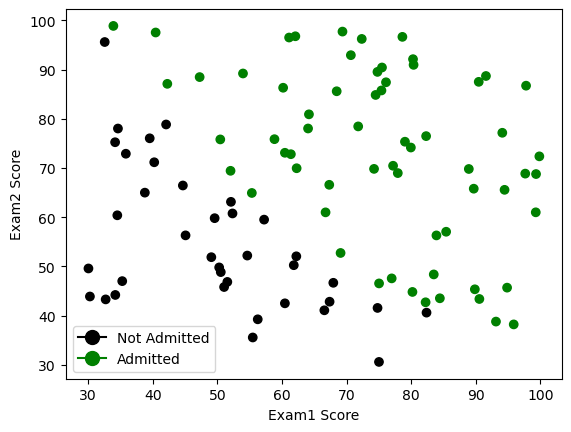

In [10]:
# Define colors and labels based on pred values
colors = np.where(pred_np == 0, 'black', 'green')
labels = np.where(pred_np == 0, 'Not Admitted', 'Admitted')

# Scatter plot with different colors based on pred
plt.scatter(features_df[:,0], features_df[:,1], c=colors,marker='o')

# Add labels and legend
plt.xlabel('Exam1 Score')
plt.ylabel('Exam2 Score')

legend_labels = ['Not Admitted', 'Admitted']
legend_markers = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for color, label in zip(['black', 'green'], legend_labels)]

# Add the legend
plt.legend(handles=legend_markers)

plt.show()


## Expected Result **

<img src = 'A8image2.png'>

Compare with the original scatter plot. Only one misclassification. So we have improved over the legacy logistic reasoning approach!<br>

<img src='A8image1.png'>



## Predict class for new data points ##

Say (50,50),(35,99),(94,38),(80,80)

In [12]:
new_features_np = np.array([[50., 50.],[35.,99.],[94.,38.],[80.,80.]])

new_features_torch=torch.from_numpy(new_features_np).float()

new_features_norm=(new_features_torch-avg_f)/std_f

#print ('new_features_norm',new_features_norm)

new_dataset = torch.utils.data.TensorDataset(new_features_norm)

# Create a data loader
new_data_loader = torch.utils.data.DataLoader(new_dataset, batch_size=4, shuffle=False)
        # Forward pass 
new_feature_pred=[]
new_pred_logits=[]
#print('model', model)
        
for i,(new_features_norm) in enumerate(new_data_loader):
        new_features_norm = new_features_norm[0]
        # Forward pass
        with torch.no_grad():
            new_predictions = model_LR(new_features_norm)
        new_pred_logits = np.append(new_pred_logits,new_predictions.detach().numpy())
        
#print('pred_logits_new', pred_logits_new)

new_feature_pred = [1 if entry >= 0 else 0 for entry in new_pred_logits]
print ('Predicted Classifications',new_feature_pred)

Predicted Classifications [0, 1, 1, 1]


## Expected Output
Predicted Classifications [0 0 0 1]<br>
Seems to make sense based on what the data sample scatter plot looks like! Neural network seems to have learnt that a very large score in Math1 will likely not lead to admittance if the Exam2 score is very low. Similarly seems to have learned that a very large score in Exam2 will likely not lead to admittance if the Exam1 score is very low

## Section 2

***Total Points 15***

## Task 1: Build a deep neural network model
**Points: 3**

Implement the `NeuralNetModel1` class. The model takes a $28\times 28$ grey-scale image as input, and passes it through a deep neural network.

The network has 2 hidden layers and 1 output layers, whose sizes are: 512 -> 512 -> 10. That is, the number of output classes is 10. The activation function for each hidden layer is `ReLU`.

The input image should first be passed through a `nn.Flatten()` layer so that a 2D tensor becomes 1D.

In [13]:
class NeuralNetModel1(nn.Module):
    def __init__(self):
        super(NeuralNetModel1, self).__init__()
        ### START YOUR CODE ###
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)
           
        
        ### END YOUR CODE ###

    def forward(self, x):
        ### START YOUR CODE ###
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        logits = self.fc3(x)
        ### END YOUR CODE ###
        return logits

In [14]:
# Do not change the test code here
sample_input = torch.randn(5, 28, 28)
print('input size:', sample_input.size())

model1 = NeuralNetModel1()
with torch.no_grad():
    output = model1(sample_input)
print('output size:', output.size())

input size: torch.Size([5, 28, 28])
output size: torch.Size([5, 10])


**Expected output**:

input size: torch.Size([5, 28, 28])\
output size: torch.Size([5, 10])

---

## Task 2: Use dataloader
**Points: 1**

Download the FashionMNIST dataset provided by PyTorch to the folder "data", which takes some time for the first time execution. The dataset is already downloaded and provided in the assignment zip folder on Canvas. The FashionMNIST dataset consists of a total of 60,000 examples for training and 10,000 examples for testing. Each example is a grayscale image of size 28x28 pixels and is associated with one of the following 10 classes:

T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot

The division is as follows:

Training set: 60,000 examples
Testing set: 10,000 examples

Use the `DataLoader` module to wrap the loaded training and test data. Specify the `batch_size` to be 64 for both training and test dataloader. So for training we will have $60000/64 = \lceil 937.5 \rceil= 938$ batches and for testing we will have $10000/64 = \lceil 156.25 \rceil= 157$

See <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader> for more information.

In [15]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True, # True
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # False
    download=True,
    transform=ToTensor()
)

batch_size = 64

### START YOUR CODE ###
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### END YOUR CODE ###

In [16]:
# Do not change the test code here. 
print('Training data size:', len(training_data))
print('Testing data size:', len(test_data))
print('No of Training Batches:', len(train_loader)) 
print('No of Test Batches:', len(test_loader)) 

count = 0
for batch in train_loader:
    X, y = batch
    print('X size:', X.size())
    print('y size:', y.size())
    count += 1
    if count > 0:
        break

Training data size: 60000
Testing data size: 10000
No of Training Batches: 938
No of Test Batches: 157
X size: torch.Size([64, 1, 28, 28])
y size: torch.Size([64])


**Expected output**:

Training data size: 60000\
Testing data size: 10000\
X size: torch.Size([64, 1, 28, 28])\
y size: torch.Size([64])

## Task 3: Define loss and optimizer
**Points: 1**

Use `nn.CrossEntropyLoss()` as the loss function, and use `torch.optim.SGD()` as the optimizer. Specify the arguments for `SGD()`, including the learning rate correctly.

See <https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html> and <https://pytorch.org/docs/stable/optim.html> for more information.

In [17]:
learning_rate = 1e-3

### START YOUR CODE ###
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model1.parameters(), lr=learning_rate)

### END YOUR CODE ###

In [18]:
# Do not change the test code here
print(loss_fn)
print(type(optimizer_sgd))

CrossEntropyLoss()
<class 'torch.optim.sgd.SGD'>


**Expected output**:

CrossEntropyLoss()<br>
<class 'torch.optim.sgd.SGD'>

---

## Task 4: Implement train and test functions
**Points: 6**

Implement the code for training the model in `train()`. Implement the code for testing the model in `test()`. For the backpropagation step, you need to first zero out all gradients by calling `optimizer.zero_grad()` before carrying out `backward()` and `step()` to update parameters.

In `test()`, you need to calculate the number of correct prediction in the current batch, and add it to the `correct` variable.
Finally, you need to divide `correct` by the total number of test examples to obtain the test accuracy.

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    for i, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        ### START YOUR CODE ###
        predictions = model(X)
        loss = loss_fn(predictions, y)
        ### END YOUR CODE ###

        # Backpropagation
        ### START YOUR CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END YOUR CODE ###

        if verbose and i % 100 == 0:
            loss = loss.item()
            current_step = i * len(X)
            print(f"loss: {loss:>7f}  [{current_step:>5d}/{len(dataloader.dataset):>5d}]")

In [53]:
@torch.no_grad()# since we dont want gradients updated
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0, 0

    for X, y in dataloader:
        ### START YOUR CODE ###
        predictions = model(X)
        test_loss += loss_fn(predictions, y).item()
        # Add the number of correct prediction in the current batch to correct
        correct += (predictions.argmax(1) == y).type(torch.float).sum().item()
        ### END YOUR CODE ###

    test_loss /= len(dataloader)
    ### START YOUR CODE ###
    test_acc = correct / len(dataloader.dataset)
    ### END YOUR CODE ###

    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Next, execute the following cell to start the training and testing loop. Make sure that the cell containing the loss function and optimizers has already been executed.

In [54]:
model1 = NeuralNetModel1() # Reset the model
### START YOUR CODE ###
model1.train()

### END YOUR CODE ###

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ### START YOUR CODE ###
    train_loop(train_loader, model1, loss_fn, optimizer_sgd, verbose=False)
    test_loop(test_loader, model1, loss_fn)
    ### END YOUR CODE ###

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 7.6%, Avg loss: 2.300207 

Done!


**Expected output**

The test accuracy from the last epoch should be above 70%.

---

Next, train an ADAM optimizer. Note that the model needs be reset. Don't specify hyper-parameter values for beta1 and beta2. Default values (0.9, 0.999) will get used.

In [55]:
model1 = NeuralNetModel1() # Reset the model

### START YOUR CODE ###
model1_optimizer = torch.optim.Adam(model1.parameters())

### END YOUR CODE ###

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ### START YOUR CODE ###
    train_loop(train_loader, model1, loss_fn, model1_optimizer, verbose=False)
    test_loop(test_loader, model1, loss_fn)
    ### END YOUR CODE ###

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.437152 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.383439 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.359631 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.342231 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.325243 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.337774 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.338464 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.347163 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.333194 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.366324 

Done!


**Expected output**:

You can find that the training converges much faster using ADAM.

---

## Task 5: Add batchnorm and dropout
**Points: 4**

Use `torch.nn.BatchNorm1d()` and `nn.Dropout()` after the ReLU activation of each hidden layer. `Batchnorm1d()` takes the size of previous activation as input. `Dropout()` takes the probability of dropout as input.

For more information, see <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> and <https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html>.

In [56]:
class NeuralNetModel2(nn.Module):
    def __init__(self, dropout = 0.1): # Note the additional dropout parameter here
        """
        :param dropout: float, the probability of dropout
        """
        super(NeuralNetModel2, self).__init__()
        ### START YOUR CODE ###
        self.fc1 = nn.Linear(sample_input.size, sample_input.hidden_size)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(sample_input.hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(sample_input.hidden_size, output.size())
        ### END YOUR CODE ###

    def forward(self, x):
        ### START YOUR CODE ###
        logits = self.fc2(self.dropout1(self.bn1(self.relu1(self.fc1(x)))))
        ### END YOUR CODE ###
        return logits

In the following cell, test with different `dropout` rates, and observe how that affects the test accuracy.

In [63]:
### START YOUR CODE ###
for dropout_rate in [0.8, 0.2, 0.3, 0.4, 0.5]:
    model = NeuralNetModel1()
    model.train()
### END YOUR CODE ###

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ### START YOUR CODE ###
    for i in range(5):
        train_loop(train_loader, model, loss_fn, optimizer_sgd, verbose=False)
        test_loop(test_loader, model, loss_fn)
    ### END YOUR CODE ###

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.300458 

Test Err

**Expected output**

In theory, you should see that the larger dropout rate you use, the lower test accuracy you will get, at the same epoch number.

But the model trained with some dropout rate should generalize better to new data.